# Loan Grade, Sub-Grade and Interest Rate Prediction

## Setup

### Imports

In [56]:
%reload_ext autoreload
%autoreload 1
import joblib
from sklearn.metrics import mean_squared_error
from pprint import pprint
from ray import tune
import copy
import shap
import matplotlib.pyplot as plt
import polars as pl
import sys
import numpy as np
from sklearn.model_selection import train_test_split
import functions.transformers as tr
from functions.transformers import PolarsColumnTransformer as PCT
import functions.data_cleaning as dmf
import functions.plot_functions as pf
import functions.tuning as tunes
import functions.statistics as st
import functions.feature_engineering as feats
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,f1_score
from sklearn.tree import DecisionTreeClassifier
from IPython.display import display,Markdown
import lightgbm as lgb
%aimport functions.tuning
%aimport functions.transformers
%aimport functions.data_cleaning
%aimport functions.plot_functions
%aimport functions.feature_engineering
%aimport functions.statistics

##### Settings:

In [55]:
ALPHA = 0.05
BASE_FIG_SIZE=(8.5,4.5)
sns.set()

### Data Preparation

##### Loading the data:

In [2]:
data_train_single=pl.read_parquet('data/data_accepted_single_train.parquet')
data_val_single=pl.read_parquet('data/data_accepted_single_val.parquet')
data_test_single=pl.read_parquet('data/data_accepted_single_test.parquet')
data_train_joint=pl.read_parquet('data/data_accepted_joint_train.parquet')
data_val_joint=pl.read_parquet('data/data_accepted_joint_val.parquet')
data_test_joint=pl.read_parquet('data/data_accepted_joint_test.parquet')

#### Oversampling

##### Sub-grades with the lowest representation in single applications:

In [3]:
data_train_single['sub_grade'].value_counts().sort('counts')[:10]

sub_grade,counts
str,u32
"""G5""",873
"""G4""",1021
"""G3""",1447
"""G2""",2003
"""G1""",2637
"""F5""",3770
"""F4""",4773
"""F3""",6078
"""F2""",7532


##### Sub-grades with the lowest representation in joint applications:

In [4]:
data_train_joint['sub_grade'].value_counts().sort('counts')[:10]

sub_grade,counts
str,u32
"""G2""",78
"""G4""",79
"""G3""",79
"""G5""",90
"""F4""",154
"""G1""",171
"""F2""",185
"""F5""",187
"""F3""",253


##### Oversampling the classes with the lowest representation:

In [3]:
data_train_single=data_train_single.vstack(st.oversample_polars(data_train_single,'sub_grade',10000))
data_train_joint=data_train_joint.vstack(st.oversample_polars(data_train_joint,'sub_grade',500))

Rare classes were over-sampled in the training set so that no sub-grade is rarer than 10000 samples in the single application set and 500 in the joint application set.

#### Data Preparation:

##### Cleaning the data:

In [4]:
data_train_single=dmf.clean_accepted_single(data_train_single)
data_val_single=dmf.clean_accepted_single(data_val_single)
data_test_single=dmf.clean_accepted_single(data_test_single)
data_train_joint=dmf.clean_accepted_joint(data_train_joint)
data_val_joint=dmf.clean_accepted_joint(data_val_joint)
data_test_joint=dmf.clean_accepted_joint(data_test_joint)

##### Dropping Features based on EDA:

In [5]:
data_train_single=dmf.remove_poor_features_single(data_train_single)
data_val_single=dmf.remove_poor_features_single(data_val_single)
data_test_single=dmf.remove_poor_features_single(data_test_single)
data_train_joint=dmf.remove_poor_features_joint(data_train_joint)
data_val_joint=dmf.remove_poor_features_joint(data_val_joint)
data_test_joint=dmf.remove_poor_features_joint(data_test_joint)

### Feature Engineering

##### Adding and modifying features:

In [6]:
data_train_single=feats.date_features(data_train_single,'issue_d')
data_val_single=feats.date_features(data_val_single,'issue_d')
data_test_single=feats.date_features(data_test_single,'issue_d')
data_train_joint=feats.date_features_joint(data_train_joint,'issue_d')
data_val_joint=feats.date_features_joint(data_val_joint,'issue_d')
data_test_joint=feats.date_features_joint(data_test_joint,'issue_d')

The following date features were changed:
1. The year of the month was changed into it's sine and cosine.
2. Earliest credit line and last credit line was transformed to represent the day difference from the current date.
3. Current year was extracted from the date.

##### Labeling grades with a sequence of numbers.

In [7]:
data_train_single=dmf.label_target_grades(data_train_single,)
data_val_single=dmf.label_target_grades(data_val_single,)
data_test_single=dmf.label_target_grades(data_test_single)
data_train_joint=dmf.label_target_grades(data_train_joint,)
data_val_joint=dmf.label_target_grades(data_val_joint,)
data_test_joint=dmf.label_target_grades(data_test_joint)

##### Specifying dependent and independent variables:

In [8]:
X_train_single=data_train_single.drop(columns=['grade','sub_grade','int_rate','issue_d'])
y_train_single=data_train_single['grade']

X_val_single=data_val_single.drop(columns=['grade','sub_grade','int_rate','issue_d'])
y_val_single=data_val_single['grade']

X_train_joint=data_train_joint.drop(columns=['grade','sub_grade','int_rate','issue_d'])
y_train_joint=data_train_joint['grade']

X_val_joint=data_val_joint.drop(columns=['grade','sub_grade','int_rate','issue_d'])
y_val_joint=data_val_joint['grade']

X_test_single=data_test_single.drop(columns=['grade','sub_grade','int_rate','issue_d'])
y_test_single=data_test_single['grade']

X_test_joint=data_test_joint.drop(columns=['grade','sub_grade','int_rate','issue_d'])
y_test_joint=data_test_joint['grade']

## Grade Prediction

### Single Applications

#### Pipeline Construction

##### Adding imputers:

In [10]:
preprocess_single=Pipeline([])
emp_title_imp = tr.NotInImputerPolars(cat_no=20, fill_value="other")
emp_length_imp = tr.NotInImputerPolars(cat_no=12, fill_value=None)
zip_imp = tr.NotInImputerPolars(cat_no=50, fill_value='other')
imputers = PCT(
    [
        PCT.Step("emp_title", emp_title_imp, "emp_title"),
        PCT.Step("emp_length", emp_length_imp, "emp_length"),
        PCT.Step("zip_code", zip_imp,'zip_code')
    ]
)
preprocess_single.steps.append(("imputers",imputers))

Features with a high number of distinct categories, such as "employment title" and "zip code," underwent a modification process using the "NotInImputer" technique. This method retains a predetermined quantity of the most frequently occurring values within these features while replacing all other less common values with a specific designated value. 

#### Adding encoders:

In [11]:
emp_t_enc = tr.TargetMeanOrderedLabeler(how="label")
emp_l_order = [
    None,
    "< 1 year",
    "1 year",
    "2 years",
    "3 years",
    "4 years",
    "5 years",
    "6 years",
    "7 years",
    "8 years",
    "9 years",
    "10+ years",
]
emp_l_enc = tr.PolarsOrdinalEncoder(order=emp_l_order)
home_enc = tr.TargetMeanOrderedLabeler(how="label")
verif_enc = tr.TargetMeanOrderedLabeler(how="label")
paymnt_enc = tr.PolarsOneHotEncoder(drop=True)
purpose_enc = tr.TargetMeanOrderedLabeler(how="label")
zip_enc = tr.TargetMeanOrderedLabeler(how="label")
state_enc = tr.TargetMeanOrderedLabeler(how="label")
init_stat_enc = tr.PolarsOneHotEncoder(drop=True)
disbursement_enc = tr.PolarsOneHotEncoder(drop=True)
year_enc = tr.TargetMeanOrderedLabeler(how="last_mean")

encoders = PCT(
    [
        PCT.Step("emp_t_enc", emp_t_enc, "emp_title"),
        PCT.Step("emp_l_enc", emp_l_enc, "emp_length"),
        PCT.Step("home_enc", home_enc, "home_ownership"),
        PCT.Step("verif_enc", verif_enc, "verification_status"),
        PCT.Step("paymnt_enc", paymnt_enc, "pymnt_plan"),
        PCT.Step("purpose_enc", purpose_enc, "purpose"),
        PCT.Step("zip_enc", zip_enc, "zip_code"),
        PCT.Step("state_enc", state_enc, "addr_state"),
        PCT.Step("init_stat_enc", init_stat_enc, "initial_list_status"),
        PCT.Step("disbursement_enc", disbursement_enc, "disbursement_method"),
        PCT.Step("year_enc", year_enc, "year")
    ]
)

preprocess_single.steps.append(("encoders",encoders))
null_imp = tr.PolarsNullImputer(fill_value=-9)
preprocess_single.steps.append(("null_imputer",null_imp))

A variety of encoding techniques were applied to handle categorical features within the dataset:

1. **One-Hot Encoding for Two-Category Features:** Two-category features were encoded using a one-hot encoding approach, resulting in a single Boolean column.

2. **Label Encoding for Inherently Unordered Categorical Data:** For inherently unordered categorical data, a label encoder was utilized. This method imparts an order to the unordered categories by calculating and the target mean and arranging the labels in accordance.

3. **Ordered Labeling for Inherently Ordered Categories:** Categories with inherent ordering, such as "employment length," were encoded using a predefined ordered labeling scheme.

4. **Encoding Current Year with Mean Interest Rate:** To encode the current year, an encoder was employed that assigns the mean interest rate from the previous year. This helps incorporate historical interest rate data into the feature.

For any remaining null values, they were substituted with the value -9 to ensure compatibility with BorutaPy, as decision-tree-based algorithms interpret this value differently, given that all other data is positive.

##### Specifying the model:

In [12]:
model_single_lgbm = lgb.LGBMClassifier(
    objective="multiclass",
    class_weight="balanced",
    verbose=-1,
    force_col_wise=True,
    random_state=1,
    num_threads=6
)

#### Feature selection 

##### Getting lists of selected features based on boruta algorithm with different strictness:

```python
original_columns = preprocess_single.fit_transform(
    X_train_single.sample(10000, seed=1), y_train_single.sample(10000, seed=1)
).columns

boruta_selected_cols = {}

transformed_sample_X = preprocess_single.fit_transform(
    X_train_single.sample(50000, seed=1), y_train_single.sample(50000, seed=1)
)
transformed_sample_y = y_train_single.sample(50000, seed=1)
for perc in np.arange(stop=101, start=10, step=10):
    boruta = tr.BorutaFeatureSelectorPolars(
        model_single_lgbm, random_state=1, perc=perc
    )

    boruta.fit(
        transformed_sample_X,
        transformed_sample_y,
    )
    boruta_selected_cols[perc] = boruta.transform(
        preprocess_single.fit_transform(
            X_train_single.sample(10000, seed=1), y_train_single.sample(10000, seed=1)
        )
    ).columns
    print(f"{perc} calculated")

# Setting the number of threads to 1 to avoid parallelization clash with ray tune.
model_single_lgbm = lgb.LGBMClassifier(
    objective="multiclass",
    class_weight="balanced",
    verbose=-1,
    force_col_wise=True,
    random_state=1,
    num_threads=1,
)

##### Getting lists of columns to drop:

```python
cols_to_drop_space=[]
for key, columns in boruta_selected_cols.items():
    cols_to_drop_space.append([col for col in original_columns if col not in columns])
cols_to_drop_space.insert(0,[])
joblib.dump(cols_to_drop_space,'temp/cols_to_drop.joblib')


In [18]:
cols_to_drop_space=joblib.load('temp/cols_to_drop.joblib')

##### Adding a feature removal step:

In [26]:
feature_dropper = tr.FeatureRemover([])
preprocess_single.steps.append(('feature_dropper',feature_dropper))
full_pipeline_single = Pipeline(
    [("preprocess", preprocess_single), ("model", model_single_lgbm)]
)

Incorporating BorutaPy directly into the pipeline proved to be impractical due to the substantial slowdown it introduced in each training iteration, particularly when the dataset featured a significant number of features. To address this issue, an alternative approach was adopted:

Several trials were conducted using different Boruta algorithm stringency settings on a sample of the data. In each trial, the selected features were identified and extracted into a list of collections of columns to be removed. This list of feature removal specifications is subsequently employed within a custom FeatureRemover transformer, allowing for manual control and tuning.

### Hyperparameter Tuning

##### Baseline for tuning:

In [17]:
full_pipeline_single.fit(X_train_single.sample(100000,seed=1),y_train_single.sample(100000,seed=1))
preds=full_pipeline_single.predict(X_val_single)
print(f1_score(y_val_single,preds,average='macro'))

0.3321204198360338


A baseline for the untuned model was established to serve as a benchmark for the early stopping of tuning trials.

#### Parameter Search Space

##### LightGBM:

In [18]:
models = tunes.Models()
search_space_lgbm = {
    "preprocess__feature_dropper__feats_to_drop": tune.choice(cols_to_drop_space),
    "model__max_depth": tune.randint(5,50),
    "model__num_leaves": tune.randint(10, 3051),
    "model__n_estimators": tune.randint(10, 251),
    "model__learning_rate": tune.loguniform(0.001, 0.1),
    "model__bagging_freq": tune.randint(0, 11),
    "model__colsample_bytree": tune.uniform(0.2, 1.0),
    "model__subsample": tune.uniform(0.2, 1.0),
    "model__reg_alpha": tune.loguniform(0.001, 100),
    "model__reg_lambda": tune.loguniform(0.001, 100),
    "model__boosting_type": tune.choice(["gbdt", "dart", "rf"]),
    "model__class_weight": tune.choice(["balanced", None]),
    "model__max_bin": tune.randint(5, 201),
}

models.add_model("lgbm_grade_single", full_pipeline_single, search_space_lgbm, metric_threshold=0.35)

##### Decision Tree:

In [19]:
preprocess_single_dtree = copy.deepcopy(preprocess_single)
model_single_dtree = DecisionTreeClassifier(random_state=1)
full_pipeline_single_dtree = Pipeline(
    [("preprocess", preprocess_single_dtree), ("model", model_single_dtree)]
)

search_space_tree = {
    "preprocess__feature_dropper__feats_to_drop": tune.choice(cols_to_drop_space),
    "model__criterion": tune.choice(["gini", "entropy"]),
    "model__splitter": tune.choice(["best", "random"]),
    "model__max_depth": tune.randint(3, 50),
    "model__max_features": tune.choice(["sqrt", "log2", None]),
    "model__class_weight": tune.choice(["balanced", None]),
}

models.add_model(
    "tree_grade_single", full_pipeline_single_dtree, search_space_tree, metric_threshold=0.3,override_n=120
)

In addition to the LightGBM model, a single decision tree model was included for the purpose of comparison. These models, along with their respective parameter configurations, were organized and managed within a dedicated "model holder" class. 

#### Parameter Tuning

```python
models.tune_all(
    X_train_single,
    y_train_single,
    X_val_single,
    y_val_single,
    n=240,
    sample_size=15000,
    average="macro",
)
joblib.dump(models, "temp/tuned_grade_models.joblib")


In [20]:
models=joblib.load('temp/tuned_grade_models.joblib')

The models were fine-tuned using the macro average of the F1 score as the primary evaluation criterion. This particular metric was selected because it places a strong emphasis on achieving a balanced and effective separation of all classes within the dataset, making it a robust measure of model performance across multiple categories or classes.

#### Tuning Results

##### Best parameters for each model:

In [28]:
for model in models.models.values():
    pprint (model.name)
    pprint(model.best_params)

'lgbm_grade_single'
{'model__bagging_freq': 9,
 'model__boosting_type': 'gbdt',
 'model__class_weight': 'balanced',
 'model__colsample_bytree': 0.6849549665551705,
 'model__learning_rate': 0.0558509334178991,
 'model__max_bin': 40,
 'model__max_depth': 33,
 'model__n_estimators': 204,
 'model__num_leaves': 2051,
 'model__reg_alpha': 0.0010009764783985519,
 'model__reg_lambda': 43.90677880592865,
 'model__subsample': 0.9796606370081837,
 'preprocess__feature_dropper__feats_to_drop': ['home_ownership',
                                                'delinq_2yrs',
                                                'fico_range_high',
                                                'mths_since_last_record',
                                                'pub_rec',
                                                'last_fico_range_low',
                                                'mths_since_last_major_derog',
                                                'acc_now_delinq',
               

The Gradient Boosting Decision Tree (GBDT) algorithm was identified as the most suitable choice. The best LightGBM model exhibited specific hyperparameters:

1. A large number of minimum leaves: The model employed 2050 minimum leaves, indicating a relatively complex tree structure.

2. Feature Removal: A total of 40 features were removed from the dataset as part of the feature selection process.

3. Slow Learning Rate: A learning rate of 0.06 was utilized.

4. A Large Number of Estimators: The model employed 204 estimators.


#### Model Selection

##### Testing the models:

In [29]:
for model in models.models.values():
    model.pipeline.fit(X_train_single,y_train_single)

preds_lgbm=models.models['lgbm_grade_single'].pipeline.predict(X_val_single)
preds_dtree=models.models['tree_grade_single'].pipeline.predict(X_val_single)
print(classification_report(y_val_single,preds_lgbm))
print(classification_report(y_val_single,preds_dtree))

              precision    recall  f1-score   support

           1       0.65      0.72      0.68     72529
           2       0.48      0.55      0.51    121365
           3       0.53      0.35      0.42    130148
           4       0.26      0.29      0.27     50567
           5       0.17      0.30      0.22     17982
           6       0.14      0.18      0.16      5509
           7       0.24      0.02      0.03      3054

    accuracy                           0.46    401154
   macro avg       0.35      0.34      0.33    401154
weighted avg       0.48      0.46      0.46    401154

              precision    recall  f1-score   support

           1       0.60      0.64      0.62     72529
           2       0.43      0.54      0.48    121365
           3       0.45      0.51      0.48    130148
           4       0.25      0.06      0.10     50567
           5       0.16      0.04      0.06     17982
           6       0.17      0.04      0.06      5509
           7       0.08 

Both the decision tree and the LightGBM model achieved an identical accuracy of 46%. However, the LightGBM model outperformed the decision tree in terms of average precision and recall. This indicates that the LightGBM model exhibits a better ability to distinguish and classify the rarer classes within the dataset, therefore it was chosen as the better model.

In [30]:
best_pipeline_single=models.models['lgbm_grade_single'].pipeline

##### Feature importance based on SHAP values:

100%|===================| 3499/3500 [55:49<00:00]        

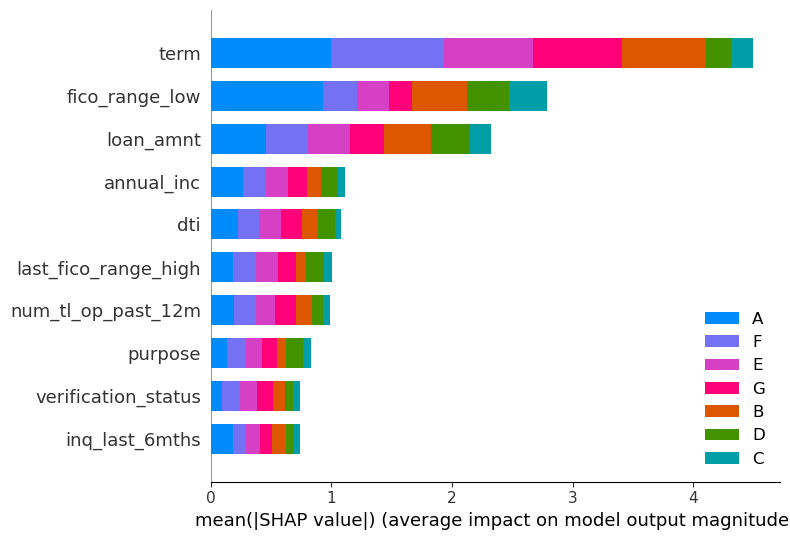

In [31]:
names = (
    models.models["lgbm_grade_single"]
    .pipeline["preprocess"]
    .transform(X_val_single.sample(500, seed=1))
    .columns
)
explainer_tree = shap.TreeExplainer(
    best_pipeline_single.pipeline["model"],
    data=best_pipeline_single
    .pipeline["preprocess"]
    .transform((X_val_single.sample(500, seed=1)))
    .to_numpy(),
    model_output="raw",
)

shap_values = explainer_tree.shap_values(
    best_pipeline_single
    .pipeline["preprocess"]
    .transform(X_val_single.sample(500, seed=1))
    .to_numpy()
)

shap.summary_plot(
    shap_values,
    best_pipeline_single
    .pipeline["preprocess"]
    .transform(X_val_single.sample(10000, seed=1))
    .to_numpy(),
    feature_names=names,
    class_names={0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 6: "G"},
    max_display=10,
)

According to SHAP, the most influential features in determining the model's predictions were:

1. Term of the loan.

2. FICO range: The range of the applicant's FICO credit score.

3. Loan amount (loan_amnt).

4. Annual income (annual_inc).

5. Debt-to-Income ratio (DTI).


#### Final Testing

In [35]:
best_pipeline_single['model'].set_params(**{'num_threads':3})

LGBMClassifier(bagging_freq=9, class_weight='balanced',
               colsample_bytree=0.6849549665551705, force_col_wise=True,
               learning_rate=0.0558509334178991, max_bin=40, max_depth=33,
               n_estimators=204, num_leaves=2051, num_threads=3,
               objective='multiclass', random_state=1,
               reg_alpha=0.0010009764783985519, reg_lambda=43.90677880592865,
               subsample=0.9796606370081837, verbose=-1)

##### Training the model on the validation and training set combined:

In [33]:
best_pipeline_single.fit(X_train_single.vstack(X_val_single),pl.concat([y_train_single,y_val_single]))

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imputers',
                                  PolarsColumnTransformer(steps=OrderedDict([('emp_title',
                                                                              <functions.transformers.PolarsColumnTransformer.Step object at 0x7f5e17ac79d0>),
                                                                             ('emp_length',
                                                                              <functions.transformers.PolarsColumnTransformer.Step object at 0x7f5e17ac74f0>),
                                                                             ('zip_code',
                                                                              <functions.transformers.PolarsColumnTransformer.Step obje...
                 LGBMClassifier(bagging_freq=9, class_weight='balanced',
                                colsample_bytree=0.6849549665551705,
                                force_col_wise=True,
                                learning_rate=0.0558509334178991, max_bin=40,
                                max_depth=33, n_estimators=204, num_leaves=2051,
                                num_threads=2, objective='multiclass',
                                random_state=1, reg_alpha=0.0010009764783985519,
                                reg_lambda=43.90677880592865,
                                subsample=0.9796606370081837, verbose=-1))])

##### Classification report of results on test data from the newest time range:

In [34]:
preds_single_final=best_pipeline_single.predict(X_test_single)
print(classification_report(y_test_single,preds_single_final))

              precision    recall  f1-score   support

           1       0.79      0.51      0.62    119923
           2       0.41      0.47      0.43    121995
           3       0.38      0.41      0.39    108373
           4       0.28      0.24      0.26     57923
           5       0.14      0.25      0.18     15356
           6       0.05      0.29      0.09      2266
           7       0.00      0.01      0.01       421

    accuracy                           0.42    426257
   macro avg       0.29      0.31      0.28    426257
weighted avg       0.48      0.42      0.44    426257



When testing the model on the final test set, which was collected from the most recent time range, the observed 3% decrease in accuracy, along with other metric changes, is likely attributable to a combination of two main factors:

1. **Overfitting:** The model may have become overfitted to the training data, resulting in a decrease in its generalization performance on unseen data. Overfitting occurs when the model captures noise or specific patterns in the training data that do not generalize well to new, unseen data.

2. **Changing Trends:** External factors, such as changes in central bank interest rates and shifts in the popularity or dynamics of the lending platform, can introduce variability and complexity into the data. These evolving trends and external factors may not have been adequately accounted for during model training.



##### Exporting the final model:

In [36]:
best_pipeline_single.fit(
    X_train_single.vstack(X_val_single).vstack(X_test_single),
    pl.concat([y_train_single, y_val_single, y_test_single]),
)

joblib.dump(best_pipeline_single, "trained_models/model_single_grade.joblib")

['trained_models/model_single_grade.joblib']

### Joint Applications

#### Pipeline

##### Setting up joint application preprocessing:

In [20]:
imputers_joint = copy.deepcopy(imputers)
encoders_joint = copy.deepcopy(encoders)
encoders_to_delete = ["disbursement_enc", "paymnt_enc"]

for key in encoders_to_delete:
    del encoders_joint.steps[key]

verif_enc_joint = tr.TargetMeanOrderedLabeler(how="label")

encoders_joint.steps["verif_enc_joint"] = PCT.Step(
    "verif_enc_joint", verif_enc_joint, "verification_status_joint"
)

null_imp_joint = copy.deepcopy(null_imp)
feature_dropper_joint = tr.FeatureRemover([])

preprocess_joint = Pipeline(
    [
        ("imputers", imputers_joint),
        ("encoders", encoders_joint),
        ("null_imputer", null_imp_joint),
        ("feature_dropper", feature_dropper_joint),
    ]
)

model_joint = lgb.LGBMClassifier(
    objective="multiclass",
    class_weight="balanced",
    verbose=-1,
    force_col_wise=True,
    random_state=1,
    num_threads=12,
)

full_pipeline_joint = Pipeline(
    [("preprocess", preprocess_joint), ("model", model_joint)]
)

#### Feature removal

Gathering the lists of important features using the Boruta Algorithm:

```python
original_columns_joint = preprocess_joint.fit_transform(
    X_train_joint.sample(10000, seed=1), y_train_joint.sample(10000, seed=1)
).columns

boruta_selected_cols_joint = {}

transformed_sample_X = preprocess_joint.fit_transform(
    X_train_joint.sample(20000, seed=1), y_train_joint.sample(20000, seed=1)
)
transformed_sample_y = y_train_joint.sample(20000, seed=1)
for perc in np.arange(stop=101, start=10, step=10):
    boruta = tr.BorutaFeatureSelectorPolars(
        model_joint, random_state=1, perc=perc
    )

    boruta.fit(
        transformed_sample_X,
        transformed_sample_y,
    )
    boruta_selected_cols_joint[perc] = boruta.transform(
        preprocess_joint.fit_transform(
            X_train_joint.sample(10000, seed=1), y_train_joint.sample(10000, seed=1)
        )
    ).columns
    print(f"{perc} calculated")

# Setting the number of threads to 1 to avoid parallelization clash with ray tune.
model_joint = lgb.LGBMClassifier(
    objective="multiclass",
    class_weight="balanced",
    verbose=-1,
    force_col_wise=True,
    random_state=1,
    num_threads=1,
)


##### Creating lists of columns to remove:

```python
cols_to_drop_space_joint=[]
for key, columns in boruta_selected_cols_joint.items():
    cols_to_drop_space_joint.append([col for col in original_columns_joint if col not in columns])
cols_to_drop_space_joint.insert(0,[])
joblib.dump(cols_to_drop_space_joint,'temp/cols_to_drop_joint.joblib')


In [29]:
cols_to_drop_space_joint=joblib.load('temp/cols_to_drop_joint.joblib')

#### Tuning

##### Parameter space:

In [24]:
search_space_lgbm_joint = {
    "preprocess__feature_dropper__feats_to_drop": tune.choice(cols_to_drop_space_joint),
    "model__max_depth": tune.randint(5,40),
    "model__num_leaves": tune.randint(10, 2500),
    "model__n_estimators": tune.randint(10, 251),
    "model__learning_rate": tune.loguniform(0.001, 0.1),
    "model__bagging_freq": tune.randint(0, 11),
    "model__colsample_bytree": tune.uniform(0.2, 1.0),
    "model__subsample": tune.uniform(0.2, 1.0),
    "model__reg_alpha": tune.loguniform(0.001, 100),
    "model__reg_lambda": tune.loguniform(0.001, 100),
    "model__boosting_type": tune.choice(["gbdt", "dart", "rf"]),
    "model__class_weight": tune.choice(["balanced", None]),
    "model__max_bin": tune.randint(5, 201),
}

joint_grade_classifier = tunes.Models.Model(
    "joint_grade_lgbm",
    pipeline=full_pipeline_joint,
    param_grid=search_space_lgbm_joint,
    metric_threshold=0.3,
)

joint_grade_classifier.pipeline['model'].set_params(**{'num_threads':1})

LGBMClassifier(class_weight='balanced', force_col_wise=True, num_threads=1,
               objective='multiclass',
               random_state=RandomState(MT19937) at 0x7F1691AA8540, verbose=-1)

##### Tuning the parameters:

```python
joint_grade_classifier.tune_model(
    X_train_joint,
    y_train_joint,
    X_val_joint,
    y_val_joint,
    n=240,
    sample_size=50000,
    n_training=1,
    average="macro",
)
joblib.dump(joint_grade_classifier, "temp/tuned_joint_grade.joblib")

In [31]:
joint_grade_classifier=joblib.load("temp/tuned_joint_grade.joblib")

##### The best parameters:

In [26]:
joint_grade_classifier.best_params

{'preprocess__feature_dropper__feats_to_drop': [],
 'model__max_depth': 23,
 'model__num_leaves': 1914,
 'model__n_estimators': 188,
 'model__learning_rate': 0.07073565588841094,
 'model__bagging_freq': 6,
 'model__colsample_bytree': 0.5167584359479642,
 'model__subsample': 0.8708296688477901,
 'model__reg_alpha': 12.533291967833335,
 'model__reg_lambda': 0.00745184747969614,
 'model__boosting_type': 'gbdt',
 'model__class_weight': None,
 'model__max_bin': 48}

The Gradient Boosting Decision Tree (GBDT) algorithm implemented with LightGBM was chosen as the best algorithm for joint applications. It's interesting that no features were dropped, and a significant alpha regularization parameter was chosen, indicating that feature selection was accomplished primarily through regularization rather than explicit feature dropping.

Introducing a time-wise performance penalty to the tuning process would be interesting. This approach can encourage the model to prefer feature dropping over heavy regularization when performance is too slow.

##### Testing the model on the validation set:

In [27]:
joint_grade_classifier.pipeline['model'].set_params(**{'num_threads':12})
joint_grade_classifier.pipeline.fit(X_train_joint,y_train_joint)
preds_joint_grade=joint_grade_classifier.pipeline.predict(X_val_joint)
print(classification_report(y_val_joint,preds_joint_grade))


              precision    recall  f1-score   support

           1       0.77      0.73      0.75      6153
           2       0.53      0.54      0.53      8269
           3       0.44      0.63      0.52      8318
           4       0.39      0.21      0.28      4926
           5       0.38      0.18      0.25      1511
           6       0.27      0.10      0.15       488
           7       0.00      0.00      0.00       137

    accuracy                           0.52     29802
   macro avg       0.40      0.34      0.35     29802
weighted avg       0.52      0.52      0.51     29802



The observation that the joint application model achieved a higher accuracy despite having significantly less data for training is likely attributable to the nature of joint applications. Joint applications are often associated with a higher creditworthiness or credit grade, which can make them easier to classify as they tend to exhibit more favorable characteristics.

However, it's worth noting that the model's difficulty in correctly identifying the lowest grade loans is a significant limitation.

##### Feature importance based on SHAP values:

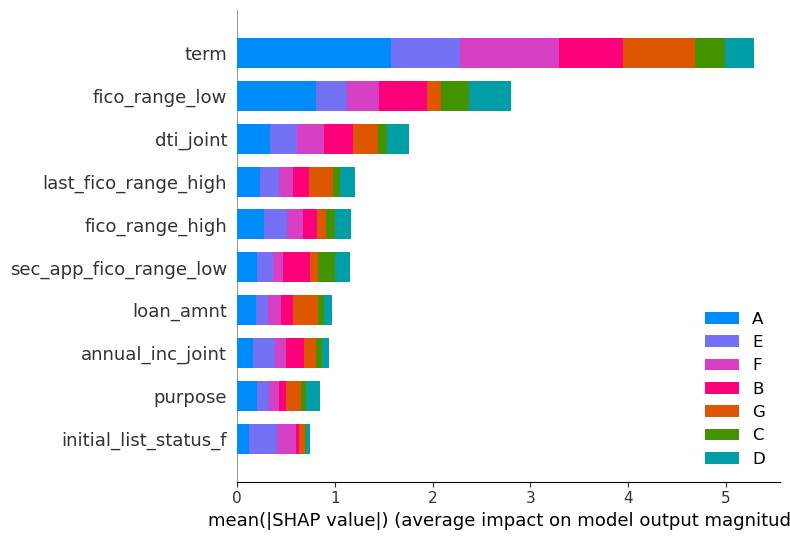

In [29]:
names_joint_grade = (
    joint_grade_classifier.pipeline["preprocess"]
    .transform(X_val_joint.sample(500, seed=1))
    .columns
)
explainer_joint_grade = shap.TreeExplainer(
    joint_grade_classifier.pipeline["model"],
    data=joint_grade_classifier.pipeline["preprocess"]
    .transform((X_val_joint.sample(500, seed=1)))
    .to_numpy(),
    model_output="raw",
)

shap_values_joint_grade = explainer_joint_grade.shap_values(
    joint_grade_classifier.pipeline["preprocess"]
    .transform(X_val_joint.sample(500, seed=1))
    .to_numpy(),
    approximate=True
)

shap.summary_plot(
    shap_values_joint_grade,
    joint_grade_classifier.pipeline["preprocess"]
    .transform(X_val_joint.sample(10000, seed=1))
    .to_numpy(),
    feature_names=names_joint_grade,
    class_names={0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 6: "G"},
    max_display=10,
)

The observation of a similar pattern of the most important features for the joint model when compared to the single application model is indicative of a consistent set of influential factors that impact loan application outcomes. This suggests that certain attributes, such as the term of the loan, FICO range, loan amount, annual income, and debt-to-income ratio, play a pivotal role in shaping loan approval decisions across both single and joint applications.

Additionally, in the joint model, the same attributes from the second applicant are incorporated. 

#### Final Testing

In [36]:
joint_grade_classifier.pipeline.fit(
    X_train_joint.vstack(X_val_joint), pl.concat([y_train_joint, y_val_joint])
)
preds_joint_grade_final = joint_grade_classifier.pipeline.predict(X_test_joint)
print(classification_report(y_test_joint, preds_joint_grade_final))

              precision    recall  f1-score   support

           1       0.76      0.76      0.76      6921
           2       0.50      0.60      0.55      8069
           3       0.47      0.38      0.42      7397
           4       0.39      0.50      0.44      4496
           5       0.30      0.11      0.16      1521
           6       0.16      0.03      0.04       275
           7       0.00      0.00      0.00        78

    accuracy                           0.53     28757
   macro avg       0.37      0.34      0.34     28757
weighted avg       0.52      0.53      0.52     28757



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


The model's accuracy increased when tested on the most recent data. This suggests that the model is adapting well to changing trends and conditions. However, the persistent difficulty in identifying the lowest grade loans indicates that there may be specific challenges or complexities associated with this subset of loan applications.

##### Exporting the final model:

In [31]:
joint_grade_classifier.pipeline.fit(
    X_train_joint.vstack(X_val_joint).vstack(X_test_joint),
    pl.concat([y_train_joint, y_val_joint, y_test_joint]),
)

joblib.dump(joint_grade_classifier.pipeline, "trained_models/model_joint_grade.joblib")

['trained_models/model_joint_grade.joblib']

## Sub-grade Prediction

##### Setting up the target variables:

In [13]:
data_train_single=dmf.label_target_sub_grades(data_train_single,)
data_val_single=dmf.label_target_sub_grades(data_val_single,)
data_test_single=dmf.label_target_sub_grades(data_test_single)
data_train_joint=dmf.label_target_sub_grades(data_train_joint,)
data_val_joint=dmf.label_target_sub_grades(data_val_joint,)
data_test_joint=dmf.label_target_sub_grades(data_test_joint)

In [14]:
y_train_single_subgrade=data_train_single['sub_grade']
y_val_single_subgrade=data_val_single['sub_grade']
y_test_single_subgrade=data_test_single['sub_grade']
y_train_joint_subgrade=data_train_joint['sub_grade']
y_val_joint_subgrade=data_val_joint['sub_grade']
y_test_joint_subgrade=data_test_joint['sub_grade']

### Single Application Sub-Grade Model

#### Setting up the pipeline:

In [27]:
preprocess_single_subgrade_cl = copy.deepcopy(preprocess_single)
preprocess_single_subgrade_rg = copy.deepcopy(preprocess_single)

model_single_sg_cl = lgb.LGBMClassifier(
    objective="multiclass",
    verbose=-1,
    force_col_wise=True,
    random_state=1,
    num_threads=1,
)

model_single_sg_rg = lgb.LGBMRegressor(
    verbose=-1, force_col_wise=True, random_state=1, num_threads=1
)
regressor_wraper_single=tr.ModelWrapper(model_single_sg_rg)

sub_grade_rounder = tr.RoundToRangeTransformer(1, 35)
pipeline_single_sg_cl = Pipeline(
    [("preprocess", preprocess_single_subgrade_cl), ("model", model_single_sg_cl)]
)
pipeline_single_sg_rg = Pipeline(
    [
        ("preprocess", preprocess_single_subgrade_rg),
        ("model", regressor_wraper_single),
        ("rounding", sub_grade_rounder),
    ]
)

In [16]:
pipeline_single_sg_cl.fit(
    X_train_single.sample(50000, seed=1), y_train_single_subgrade.sample(50000, seed=1)
)
pipeline_single_sg_rg.fit(
    X_train_single.sample(50000, seed=1), y_train_single_subgrade.sample(50000, seed=1)
)

initial_preds_sg_cl = pipeline_single_sg_cl.predict(X_val_single.sample(10000, seed=1))
initial_preds_sg_rg = pipeline_single_sg_rg.predict(X_val_single.sample(10000, seed=1))

print(
    f1_score(
        y_val_single_subgrade.sample(10000, seed=1),
        initial_preds_sg_cl,
        average="macro",
    )
)
print(
    f1_score(
        y_val_single_subgrade.sample(10000, seed=1),
        initial_preds_sg_rg,
        average="macro",
    )
)

0.06784539357949627
0.0775470528150547


#### Tuning

In [28]:
models_sub_single = tunes.Models()
search_space_sg_cl = {
    "preprocess__feature_dropper__feats_to_drop": tune.choice(cols_to_drop_space),
    "model__max_depth": tune.randint(5,40),
    "model__num_leaves": tune.randint(10, 2500),
    "model__n_estimators": tune.randint(10, 251),
    "model__learning_rate": tune.loguniform(0.001, 0.1),
    "model__bagging_freq": tune.randint(0, 11),
    "model__colsample_bytree": tune.uniform(0.2, 1.0),
    "model__subsample": tune.uniform(0.2, 1.0),
    "model__reg_alpha": tune.loguniform(0.001, 100),
    "model__reg_lambda": tune.loguniform(0.001, 100),
    "model__boosting_type": tune.choice(["gbdt", "dart", "rf"]),
    "model__class_weight": tune.choice(["balanced", None]),
    "model__max_bin": tune.randint(5, 201),
}

models_sub_single.add_model("cl_subgrade_single", pipeline_single_sg_cl, search_space_sg_cl, metric_threshold=0.1)

In [29]:
search_space_sg_rg = {
    "preprocess__feature_dropper__feats_to_drop": tune.choice(cols_to_drop_space),
    "model__param_grid": {
        "num_leaves": tune.randint(10, 2500),
        "max_depth": tune.randint(10,40),
        "n_estimators": tune.randint(10, 251),
        "learning_rate": tune.loguniform(0.001, 0.1),
        "bagging_freq": tune.randint(0, 11),
        "colsample_bytree": tune.uniform(0.2, 1.0),
        "subsample": tune.uniform(0.2, 1.0),
        "reg_alpha": tune.loguniform(0.001, 100),
        "reg_lambda": tune.loguniform(0.001, 100),
        "boosting_type": tune.choice(["gbdt", "dart", "rf"]),
        "class_weight": tune.choice(["balanced", None]),
        "max_bin": tune.randint(5, 256),
    },
}

models_sub_single.add_model(
    "rg_subgrade_single",
    pipeline_single_sg_rg,
    search_space_sg_rg,
    metric_threshold=0.1,
)

```python
models_sub_single.tune_all(X_train_single,
    y_train_single_subgrade,
    X_val_single,
    y_val_single_subgrade,
    n=240,
    n_training = 3,
    sample_size=15000,
    average="macro",)

joblib.dump(models_sub_single,'temp/models_sub_single.joblib')

In [ ]:
models_sub_single=joblib.load('temp/models_sub_single.joblib')

best params

In [36]:
models_sub_single.models

{'cl_subgrade_single': <functions.tuning.Models.Model at 0x7fc46def8dc0>,
 'rg_subgrade_single': <functions.tuning.Models.Model at 0x7fc46defa0d0>}

In [37]:
for model in models_sub_single.models.values():
    pprint(model.best_params)

{'model__bagging_freq': 3,
 'model__boosting_type': 'gbdt',
 'model__class_weight': 'balanced',
 'model__colsample_bytree': 0.7402382756527682,
 'model__learning_rate': 0.08034565850796604,
 'model__max_bin': 137,
 'model__max_depth': 8,
 'model__n_estimators': 231,
 'model__num_leaves': 1116,
 'model__reg_alpha': 0.0146906759526997,
 'model__reg_lambda': 6.4939727257369855,
 'model__subsample': 0.4094460840515235,
 'preprocess__feature_dropper__feats_to_drop': ['home_ownership',
                                                'addr_state',
                                                'delinq_2yrs',
                                                'fico_range_high',
                                                'mths_since_last_delinq',
                                                'mths_since_last_record',
                                                'open_acc',
                                                'pub_rec',
                                                'last_fi

In [43]:
preds_subgrade_single={}
for name, model in models_sub_single.models.items():
    model.pipeline.fit(X_train_single,y_train_single_subgrade)
    preds_subgrade_single[name]=model.pipeline.predict(X_val_single)
    print(name)
    print(classification_report(y_val_single_subgrade,preds_subgrade_single[name]))


cl_subgrade_single
              precision    recall  f1-score   support

           1       0.42      0.44      0.43     15383
           2       0.17      0.21      0.19     12260
           3       0.13      0.19      0.15     13287
           4       0.11      0.19      0.14     13613
           5       0.14      0.10      0.12     17986
           6       0.19      0.13      0.15     25290
           7       0.11      0.09      0.10     22268
           8       0.09      0.25      0.13     23595
           9       0.08      0.07      0.08     21745
          10       0.12      0.09      0.10     28467
          11       0.12      0.06      0.08     29441
          12       0.10      0.08      0.09     24529
          13       0.12      0.03      0.05     24407
          14       0.12      0.03      0.05     25222
          15       0.12      0.04      0.06     26549
          16       0.05      0.07      0.06     12655
          17       0.06      0.12      0.08     11964
        

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


              precision    recall  f1-score   support

           1       0.56      0.23      0.33     15383
           2       0.23      0.18      0.20     12260
           3       0.15      0.13      0.14     13287
           4       0.13      0.14      0.13     13613
           5       0.14      0.13      0.13     17986
           6       0.13      0.10      0.11     25290
           7       0.10      0.11      0.11     22268
           8       0.10      0.12      0.11     23595
           9       0.09      0.14      0.11     21745
          10       0.11      0.12      0.12     28467
          11       0.11      0.12      0.11     29441
          12       0.10      0.12      0.11     24529
          13       0.10      0.11      0.10     24407
          14       0.11      0.10      0.10     25222
          15       0.12      0.09      0.10     26549
          16       0.06      0.07      0.07     12655
          17       0.05      0.06      0.06     11964
          18       0.07    

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [46]:
from sklearn.metrics import mean_squared_error
for name,preds in preds_subgrade_single.items():
    print(name)
    print(f'RMSE: {mean_squared_error(y_val_single_subgrade,preds)}')

cl_subgrade_single
RMSE: 30.602950487842573
rg_subgrade_single
RMSE: 19.702707688319197


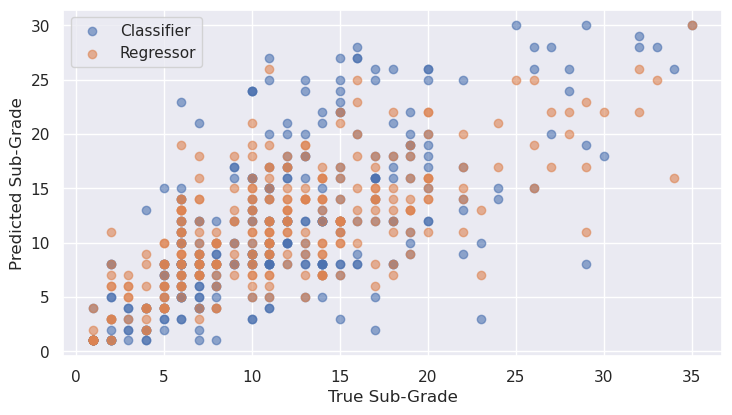

In [65]:
fig_rg_cl, ax_rg_cl = plt.subplots(figsize=BASE_FIG_SIZE)
ax_rg_cl.scatter(
    y_val_single_subgrade[:300],
    preds_subgrade_single["cl_subgrade_single"][:300],
    alpha=0.6,
    label='Classifier'
)
ax_rg_cl.scatter(
    y_val_single_subgrade[:300],
    preds_subgrade_single["rg_subgrade_single"][:300],
    alpha=0.6,
    label = 'Regressor'
)
ax_rg_cl.legend()
ax_rg_cl.set_xlabel('True Sub-Grade')
ax_rg_cl.set_ylabel('Predicted Sub-Grade')
plt.show()

In [67]:
best_pipeline_single_sub=models_sub_single.models['rg_subgrade_single'].pipeline

In [75]:
shap_values_single_subgrade.shape

(500, 28)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


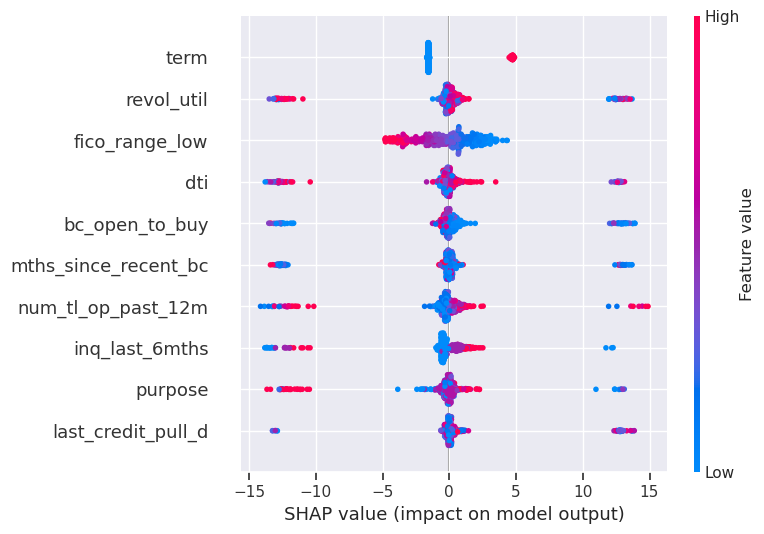

In [76]:
names_single_subgrade = (
    best_pipeline_single_sub["preprocess"]
    .transform(X_val_single.sample(500, seed=1))
    .columns
)
explainer_single_subgrade = shap.TreeExplainer(
    best_pipeline_single_sub["model"].model,
    data=best_pipeline_single_sub["preprocess"]
    .transform((X_val_single.sample(500, seed=1)))
    .to_numpy(),
    model_output="raw",
)

shap_values_single_subgrade = explainer_single_subgrade.shap_values(
    best_pipeline_single_sub["preprocess"]
    .transform(X_val_single.sample(500, seed=1))
    .to_numpy(),
    approximate=True
)

shap.summary_plot(
    shap_values_single_subgrade,
    best_pipeline_single_sub["preprocess"]
    .transform(X_val_single.sample(500, seed=1))
    .to_numpy(),
    feature_names=names_single_subgrade,
    max_display=10,
)

Final testing:

In [ ]:
best_pipeline_single['model'].set_params(**{'num_threads':6})
best_pipeline_single.fit(X_train_single.vstack(X_val_single),pl.concat([y_train_single,y_val_single]))
preds_single_final=best_pipeline_single.predict(X_test_single)
print(classification_report(y_test_single,preds_single_final))